# Step 1 - Load Training set
Now we load datas that three camera datas(left, center and right) and steering from the simulation training data.

In [0]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 37.69 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
!ls track

driving_log.csv  IMG


IMG is directory has image files(three cams).
driving_log has image file urls, speed, steering and direction


In [0]:
!pip3 install imgaug


    100% |████████████████████████████████| 17.3MB 2.7MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


* ** [Imgaug](https://imgaug.readthedocs.io/en/latest/)** -  is a library for image augmentation in machine learning experiments. It supports a wide range of augmentation techniques, allows to easily combine these and to execute them in random order or on multiple CPU cores, has a simple yet powerful stochastic interface and can not only augment images, but also keypoints/landmarks, bounding boxes, heatmaps and segmentation maps. 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import random
import ntpath


Using TensorFlow backend.


In [0]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
pd.set_option('display.max_colwidth', -1)
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
data.head()

center  \
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg   

                                                                   left  \
0  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg   

                                                                   right  \
0  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg   
1  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg   
2  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg   
3  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg   
4  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.649786  
1  0.0       0.0       0.0      0.627942  
2  0.0       0.0       0.0      0.622910  
3  0.0       0.0       0.0      0.619162  
4  0.0       0.0       0.0      0.615438

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail 

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg  0.0       0.0       0.0      0.649786  
1  right_2018_07_16_17_11_43_670.jpg  0.0       0.0       0.0      0.627942  
2  right_2018_07_16_17_11_43_724.jpg  0.0       0.0       0.0      0.622910  
3  right_2018_07_16_17_11_43_792.jpg  0.0       0.0       0.0      0.619162  
4  right_2018_07_16_17_11_43_860.jpg  0.0       0.0       0.0      0.615438

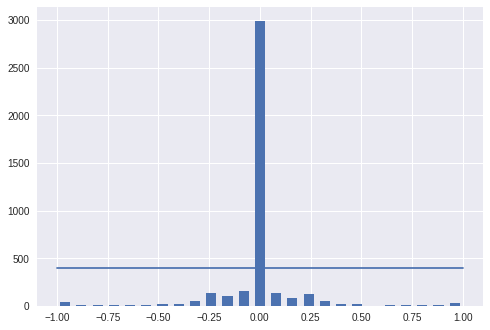

In [0]:
num_bins = 25
samples_per_bin = 400
# hist: 도수분포표의 각 구간에 있는 data의 수, bins: 도수분포 구간
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
# print(bins)
# print(bins[:-1])
# print(bins[1:])
# print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# plt.plot((-0.5, 0.5), (1000, 1000))

total data: 4053
removed: 2590
remaining 1463


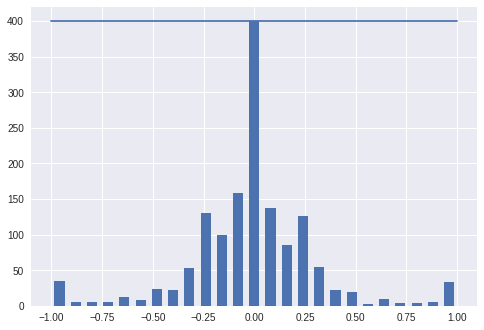

In [0]:
print('total data:', len(data))
removed_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1] :
      list_.append(i)

  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]  # 300 부터 뒤까지 제거하기 위해
  removed_list.extend(list_)
  # append는 뒤에 object를 추가, extend는 iterable 객체의 엘리먼트를 뒤에 append한다

print('removed:', len(removed_list))
data.drop(data.index[removed_list], inplace=True) # drop한 후의 데이터프레임으로 기존 데이터프레임을 대체하겠다는 뜻
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
# print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i] # integer positon를 통해 값을 찾을 수 있다. label로는 찾을 수 없다
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip())) # strip: 공백제거
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path) # copy가 true인 array
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
print(image_paths)
print(steerings)

['track/IMG/center_2018_07_16_17_11_43_792.jpg'
 'track/IMG/center_2018_07_16_17_11_43_930.jpg'
 'track/IMG/center_2018_07_16_17_11_44_069.jpg' ...
 'track/IMG/center_2018_07_16_17_16_29_833.jpg'
 'track/IMG/center_2018_07_16_17_16_30_417.jpg'
 'track/IMG/center_2018_07_16_17_16_31_685.jpg']
[0.         0.         0.         ... 0.09723174 0.         0.        ]


In [0]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6) # random_state: seed
print("Training samples: {}\nValid samples: {}".format(len(X_train), len(X_valid)))
print(X_train)

Training samples: 1170
Valid samples: 293
['track/IMG/center_2018_07_16_17_13_41_217.jpg'
 'track/IMG/center_2018_07_16_17_13_58_243.jpg'
 'track/IMG/center_2018_07_16_17_14_29_338.jpg' ...
 'track/IMG/center_2018_07_16_17_12_26_364.jpg'
 'track/IMG/center_2018_07_16_17_13_59_386.jpg'
 'track/IMG/center_2018_07_16_17_14_32_141.jpg']


Text(0.5, 1.0, 'Validation set')

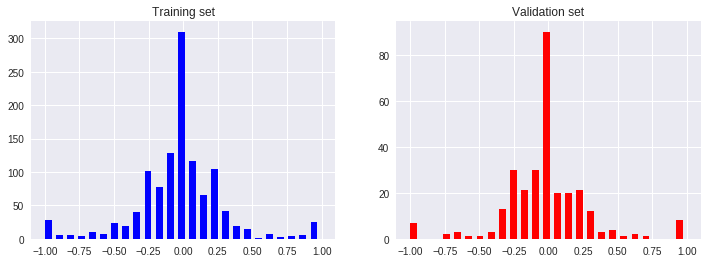

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4)) 
axs[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axs[0].set_title('Training set')
axs[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axs[1].set_title('Validation set')

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed Image')

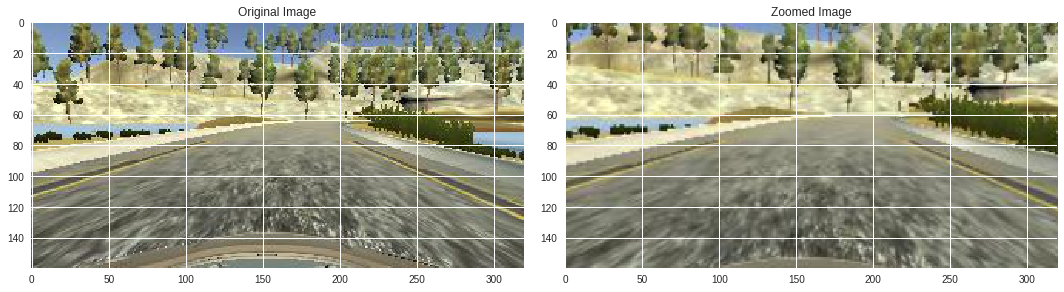

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent = {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

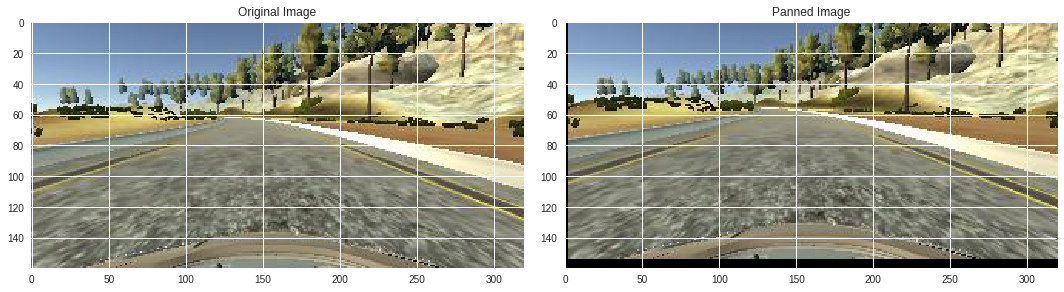

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')


In [0]:
def img_random_brightness(image): # multiplies all the pixel intensities inside the image, thus any pixel intensity multiplied by a value less than 1 will become darker
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness altered Image')

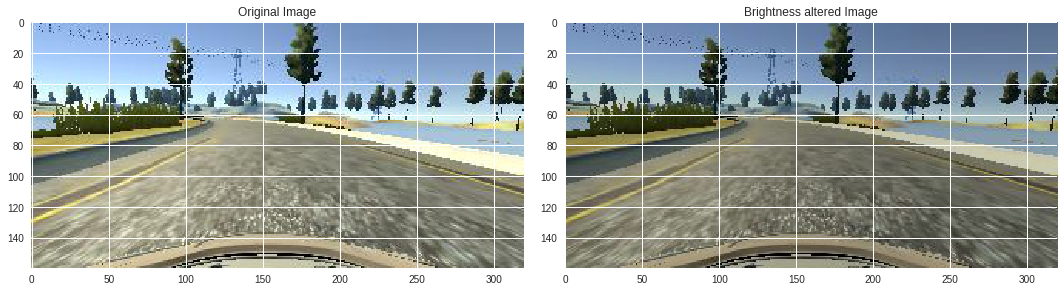

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered Image')

In [0]:
def img_random_flip(image, steering_angle):
  image = cv2.flip(image, 1) # 0: vertical flip, 1: horizontal flip, -1: combination of both horizontal and vertical
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle: -0.1543404')

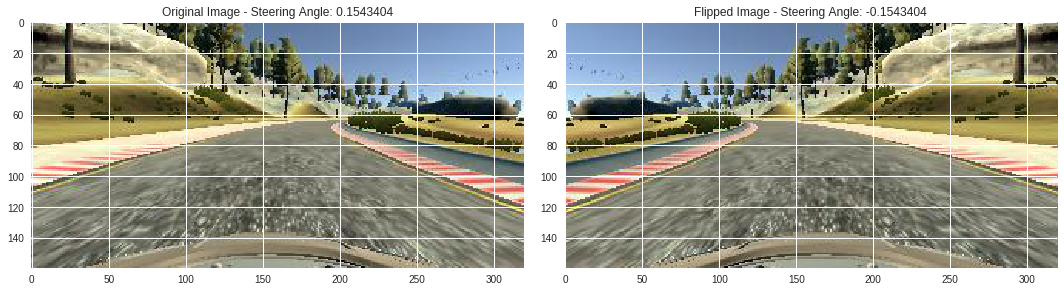

In [0]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle: ' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle: ' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
    
  return image, steering_angle
  

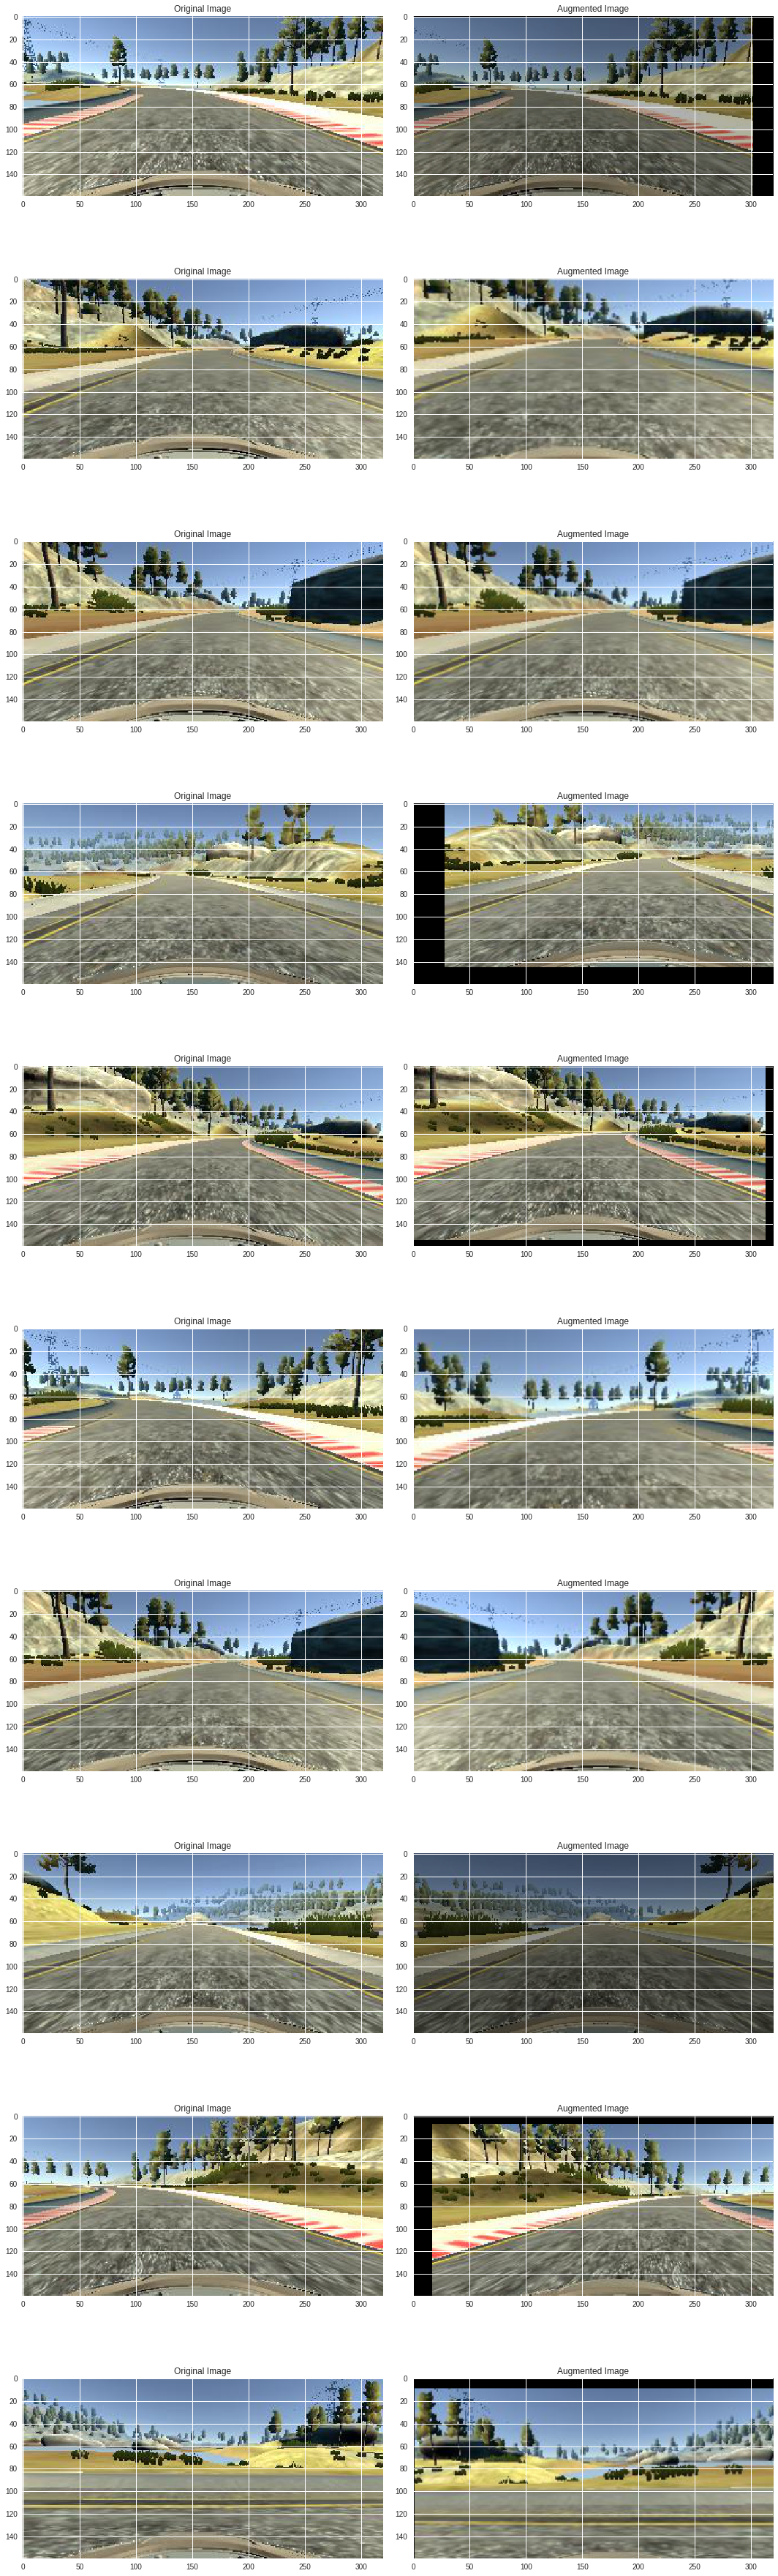

In [0]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  
  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')


In [0]:
def img_preprocess(img):
  img = img[60:135, :, :] # height, width, channel # 카메라에 투영되는 차량의 앞부분을 제거한다
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # nvidia model에서 추천함 ㅎ
  img = cv2.GaussianBlur(img, (3, 3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255  
  
  return img


Text(0.5, 1.0, 'Preprocessed Image')

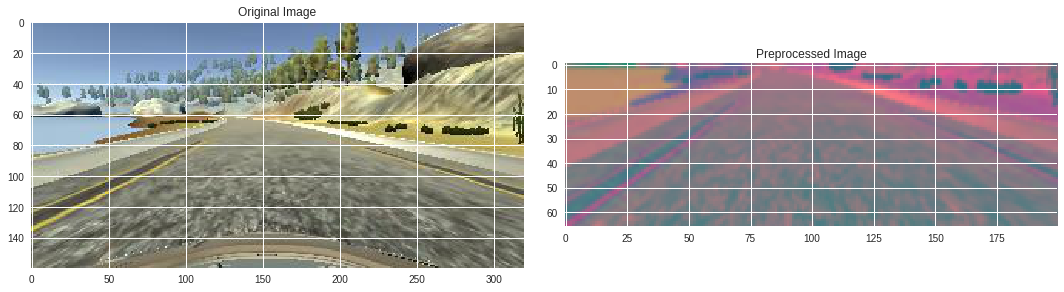

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

[[[0.15686275 0.49019608 0.51764706]
  [0.15294118 0.49411765 0.50980392]
  [0.14117647 0.49411765 0.49411765]
  ...
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]]

 [[0.1372549  0.49411765 0.50980392]
  [0.14117647 0.49411765 0.50588235]
  [0.1372549  0.49803922 0.49019608]
  ...
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]]

 [[0.14117647 0.49803922 0.49803922]
  [0.14509804 0.49803922 0.49803922]
  [0.14509804 0.50196078 0.49019608]
  ...
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]]

 ...

 [[0.19215686 0.49019608 0.50980392]
  [0.21960784 0.49019608 0.50588235]
  [0.25490196 0.48627451 0.50980392]
  ...
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]
  [0.         0.50196078 0.50196078]]

 [[0.19607843 0.49019608 0.50980392]
  [0.21568627 0.49019608 0.50588235]


Text(0.5, 1.0, 'Validation Image')

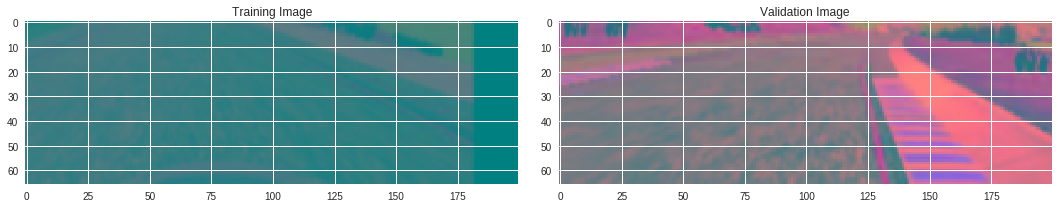

In [0]:
X_train_gen, Y_train_gen = next(batch_generator(X_train, Y_train, 1, 1))
X_valid_gen, Y_valid_gen = next(batch_generator(X_valid, Y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

print(X_train_gen[0])


axs[0].imshow(X_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(X_valid_gen[0])
axs[1].set_title('Validation Image')


In [0]:
def nvidia_model():
  model = Sequential()
  # subsample: (horizontally moving, vertically moving)
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(1)) # output is steering angle
  
  optimizer = Adam(lr=1e-4)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [0]:
model = nvidia_model()
print(model.summary())



Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [0]:
history = model.fit_generator(batch_generator(X_train, Y_train, 100, 1), 
                             steps_per_epoch=300, 
                             epochs=10, 
                             validation_data=batch_generator(X_valid, Y_valid, 100, 0), 
                             validation_steps=200, 
                             verbose=1, 
                             shuffle=1)
                             
  



Instructions for updating:
Use tf.cast instead.
Epoch 1/10
300/300 [==============================] - 171s 569ms/step - loss: 0.0764 - val_loss: 0.0542
Epoch 2/10
300/300 [==============================] - 162s 540ms/step - loss: 0.0568 - val_loss: 0.0428
Epoch 3/10
300/300 [==============================] - 166s 552ms/step - loss: 0.0502 - val_loss: 0.0351
Epoch 4/10
300/300 [==============================] - 174s 582ms/step - loss: 0.0457 - val_loss: 0.0362
Epoch 5/10
300/300 [==============================] - 165s 552ms/step - loss: 0.0433 - val_loss: 0.0377
Epoch 6/10
300/300 [==============================] - 162s 541ms/step - loss: 0.0428 - val_loss: 0.0305
Epoch 7/10
300/300 [==============================] - 168s 562ms/step - loss: 0.0404 - val_loss: 0.0279
Epoch 8/10
300/300 [==============================] - 167s 556ms/step - loss: 0.0380 - val_loss: 0.0279
Epoch 9/10
300/300 [==============================] - 160s 534ms/step - loss: 0.0378 - val_loss: 0.0282
Epoch 10/10
300/

Text(0.5, 0, 'Epoch')

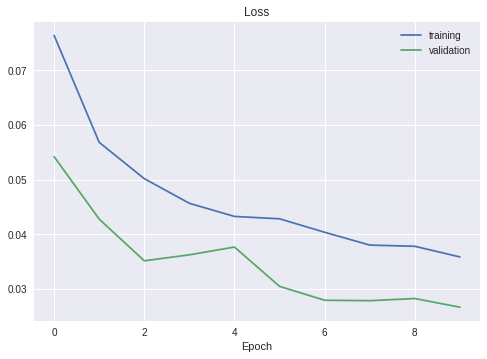

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel("Epoch")

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')